In [80]:
import pandas as pd
import numpy as np

def get_target_weights(csv_path, target_names):
    df = pd.read_csv(csv_path)

    scale_normalization_factors = []
    sample_count_normalization_factors = []
    for target in target_names:
        target_values = df[target].values
        target_values = target_values[~np.isnan(target_values)]

        scale_normalization_factors.append(1 / (max(target_values) - min(target_values)))
        sample_count_normalization_factors.append((1/len(target_values))**0.5)

    scale_normalization_factors = np.array(scale_normalization_factors)
    sample_count_normalization_factors = np.array(sample_count_normalization_factors)

    target_weights = scale_normalization_factors * len(target_names) * sample_count_normalization_factors / sum(sample_count_normalization_factors)

    return target_weights

TARGET_NAMES = ["Tg", "FFV", "Tc", "Density", "Rg"]
target_weights = get_target_weights('../../data/from_host/train.csv', TARGET_NAMES)

In [81]:
from typing import List, Tuple
import numpy as np

def average_groups_by_label(labels: List[float], predictions: List[float]) -> Tuple[np.ndarray, np.ndarray]:
    """
    Collapse repeated TTA samples into single averaged entries by grouping
    consecutive identical labels.

    Parameters
    ----------
    labels : list of float
        The ground truth labels, repeated for each TTA sample.
    predictions : list of float
        The model predictions corresponding to each label.

    Returns
    -------
    averaged_labels : np.ndarray
        One label per raw input (all repeats collapsed).
    averaged_predictions : np.ndarray
        The average prediction across repeats for each raw input.
    """
    if len(labels) != len(predictions):
        raise ValueError("labels and predictions must be the same length")

    averaged_labels = []
    averaged_predictions = []

    current_label = labels[0]
    current_preds = [predictions[0]]

    for label, pred in zip(labels[1:], predictions[1:]):
        if label == current_label:
            current_preds.append(pred)
        else:
            averaged_labels.append(current_label)
            averaged_predictions.append(np.mean(current_preds))
            current_label = label
            current_preds = [pred]

    # flush the last group
    averaged_labels.append(current_label)
    averaged_predictions.append(np.mean(current_preds))

    return np.array(averaged_labels), np.array(averaged_predictions)

In [82]:
from typing import Iterable, Literal, Optional, Tuple
import numpy as np

def _weighted_median(values: np.ndarray, weights: np.ndarray) -> float:
    order = np.argsort(values, kind="mergesort")
    sorted_values = values[order]
    sorted_weights = weights[order]
    cumulative_weights = np.cumsum(sorted_weights)
    half_total = 0.5 * sorted_weights.sum()
    median_index = np.searchsorted(cumulative_weights, half_total, side="right")
    median_index = min(median_index, len(sorted_values) - 1)
    return float(sorted_values[median_index])

def _pav_l1(values: np.ndarray, weights: np.ndarray) -> np.ndarray:
    """
    Median-based PAV for L1 isotonic regression on a 1D sequence.
    Returns fitted (isotonic, nondecreasing) z for each position.
    """
    n = len(values)
    fitted_values = np.empty(n, dtype=float)

    # Each block: (start_index, end_index_inclusive, values_array, weights_array, block_value)
    blocks = []
    for index in range(n):
        v = values[index:index+1]
        w = weights[index:index+1]
        block_value = _weighted_median(v, w)
        blocks.append([index, index, v, w, block_value])

        # Merge while monotonicity is violated
        while len(blocks) >= 2 and blocks[-2][4] > blocks[-1][4]:
            left = blocks[-2]
            right = blocks[-1]
            merged_start = left[0]
            merged_end = right[1]
            merged_vals = np.concatenate([left[2], right[2]])
            merged_wgts = np.concatenate([left[3], right[3]])
            merged_value = _weighted_median(merged_vals, merged_wgts)
            blocks[-2] = [merged_start, merged_end, merged_vals, merged_wgts, merged_value]
            blocks.pop()

    # Write out block values
    for start_index, end_index, _vals, _wgts, block_value in blocks:
        fitted_values[start_index:end_index+1] = block_value

    return fitted_values

class L1IsotonicRegression:
    """
    Drop-in style replacement for sklearn.isotonic.IsotonicRegression that minimizes MAE (L1)
    using a median-based Pool-Adjacent-Violators (PAV) algorithm.

    Parameters
    ----------
    increasing : bool | "auto", default="auto"
        If True, fit a nondecreasing function. If False, fit nonincreasing.
        If "auto", fit both and choose the lower L1 loss.
    y_min : Optional[float], default=None
        Lower bound to clip fitted values after fitting (if not None).
    y_max : Optional[float], default=None
        Upper bound to clip fitted values after fitting (if not None).
    out_of_bounds : {"clip", "nan"}, default="clip"
        Behavior for predict() outside the training X range.

    Attributes (sklearn-compatible names)
    ----------
    X_thresholds_ : np.ndarray
        Sorted unique X breakpoints used for interpolation.
    y_thresholds_ : np.ndarray
        Corresponding fitted values (monotone) at breakpoints.
    increasing_ : bool
        The direction chosen during fit.
    y_min_ : Optional[float]
    y_max_ : Optional[float]
    """

    def __init__(
        self,
        increasing: Literal[True, False, "auto"] = "auto",
        y_min: Optional[float] = None,
        y_max: Optional[float] = None,
        out_of_bounds: Literal["clip", "nan"] = "clip",
    ):
        self.increasing = increasing
        self.y_min = y_min
        self.y_max = y_max
        self.out_of_bounds = out_of_bounds

    def fit(
        self,
        X: Optional[Iterable[float]],
        y: Iterable[float],
        sample_weight: Optional[Iterable[float]] = None,
    ) -> "L1IsotonicRegression":
        y = np.asarray(y, dtype=float)
        n = y.shape[0]
        if X is None:
            X = np.arange(n, dtype=float)
        else:
            X = np.asarray(X, dtype=float)
        if X.shape[0] != n:
            raise ValueError("X and y must have the same length")

        if sample_weight is None:
            sample_weight = np.ones(n, dtype=float)
        else:
            sample_weight = np.asarray(sample_weight, dtype=float)
            if sample_weight.shape[0] != n:
                raise ValueError("sample_weight must have same length as y")

        # Sort by X, and within ties preserve order (mergesort) for stability
        order = np.argsort(X, kind="mergesort")
        sorted_X = X[order]
        sorted_y = y[order]
        sorted_w = sample_weight[order]

        def _fit_one_direction(increasing_flag: bool) -> Tuple[np.ndarray, float]:
            if increasing_flag:
                z = _pav_l1(sorted_y, sorted_w)
            else:
                z_rev = _pav_l1(sorted_y[::-1], sorted_w[::-1])
                z = z_rev[::-1]
            # Clip to bounds if provided
            if self.y_min is not None:
                z = np.maximum(z, self.y_min)
            if self.y_max is not None:
                z = np.minimum(z, self.y_max)
            l1_loss = np.sum(np.abs(z - sorted_y) * sorted_w)
            return z, l1_loss

        if self.increasing == "auto":
            z_inc, loss_inc = _fit_one_direction(True)
            z_dec, loss_dec = _fit_one_direction(False)
            if loss_inc <= loss_dec:
                chosen_increasing = True
                z_fit = z_inc
            else:
                chosen_increasing = False
                z_fit = z_dec
        else:
            chosen_increasing = bool(self.increasing)
            z_fit, _ = _fit_one_direction(chosen_increasing)

        # Reduce to thresholds at unique X (last value per unique X is fine for monotone)
        unique_mask = np.concatenate(([True], np.diff(sorted_X) != 0.0))
        X_thresholds = sorted_X[unique_mask]
        y_thresholds = z_fit[unique_mask]

        self.X_thresholds_ = X_thresholds
        self.y_thresholds_ = y_thresholds
        self.increasing_ = chosen_increasing
        self.y_min_ = self.y_min
        self.y_max_ = self.y_max
        return self

    def predict(self, X: Iterable[float]) -> np.ndarray:
        if not hasattr(self, "X_thresholds_"):
            raise RuntimeError("Model is not fitted. Call fit() first.")
        X = np.asarray(X, dtype=float)

        if self.out_of_bounds == "clip":
            left_value = self.y_thresholds_[0]
            right_value = self.y_thresholds_[-1]
            predictions = np.interp(X, self.X_thresholds_, self.y_thresholds_, left=left_value, right=right_value)
        elif self.out_of_bounds == "nan":
            predictions = np.interp(X, self.X_thresholds_, self.y_thresholds_)
            predictions[(X < self.X_thresholds_[0]) | (X > self.X_thresholds_[-1])] = np.nan
        else:
            raise ValueError('out_of_bounds must be "clip" or "nan"')

        return predictions


Tg: 37.7747
FFV: 0.0039
Tc: 0.0193
Density: 0.0169
Rg: 1.0621

wMAE: 0.04810


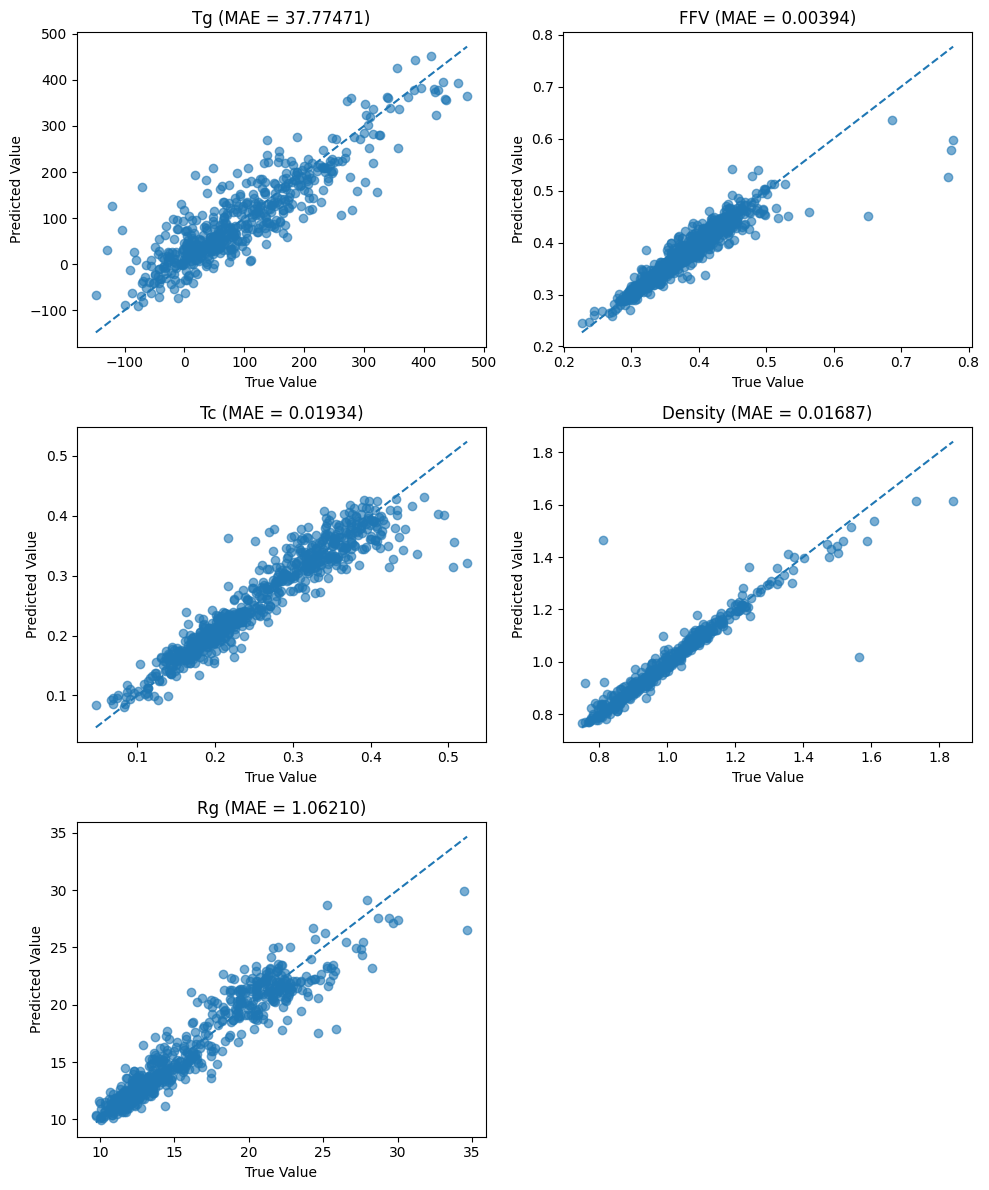

'\nTg: 38.5344\nFFV: 0.0039\nTc: 0.0202\nDensity: 0.0175\nRg: 1.0798\n'

In [108]:
import pickle
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold

ROOT_MODEL_PATHS = [
    # '../../models/20250728_083626_modern_et_8',
    # '../../models/20250906_150824_codebert_et_8',
    # '../../models/20250728_073119_poly_et_32',
    # '../../models/20250903_235317_modern_large',

    # '../../models/20250823_163627_modern_tuned',
    # # '../../models/20250823_160519_polyBERT_tuned',
    # '../../models/20250908_185141_codebert_tuned',

    '../../models/20250913_092729_modern_tuned_v2.1',
    '../../models/20250823_160519_polyBERT_tuned',
    # # '../../models/20250913_055810_polyBERT_tuned_v2.1',
    '../../models/20250913_114530_codebert_tuned_v2.2',

    '../../models/20250914_161509_codebert_tuned_v3',
    '../../models/20250914_161920_modern_tuned_v3'
]
MODEL_WEIGHTS = [
    # 0.5, 0.5, 
    1, 0, 1.5,
    .5, .5
]
# MODEL_WEIGHTS = [1,0,1.5]

figure, axes_array = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 12))
axes_array = axes_array.flatten()

maes = []
for subplot_index,target_name in enumerate(TARGET_NAMES):
    all_oof_preds = []
    all_oof_labels = []
    for root_model_path in ROOT_MODEL_PATHS:
        model_oof_preds = []
        model_oof_labels = []
        for fold_index in range(5):
            fold_directory_path = f'{root_model_path}/fold_{fold_index}'
            with open(f'{fold_directory_path}/oof_preds_{target_name}.pkl', 'rb') as f:
                fold_oof_preds = pickle.load(f)
            with open(f'{fold_directory_path}/oof_labels_{target_name}.pkl', 'rb') as f:
                fold_oof_labels = pickle.load(f)

            model_oof_preds.extend(fold_oof_preds)
            model_oof_labels.extend(fold_oof_labels)

        # model_oof_preds = np.array(model_oof_preds)
        # model_oof_preds = model_oof_preds.reshape(-1, 25).mean(axis=1)
        # all_oof_labels = np.array(model_oof_preds)
        # all_oof_labels = all_oof_labels.reshape(-1, 25).mean(axis=1)

        model_oof_labels, model_oof_preds = average_groups_by_label(model_oof_labels, model_oof_preds)

        # print(list(model_oof_labels[:30]))
        all_oof_preds.append(np.array(model_oof_preds))
        all_oof_labels.append(np.array(model_oof_labels))
        # print(len(model_oof_preds))

    # ensemble_oof_preds = np.mean(np.array(all_oof_preds), axis=0)
    ensemble_oof_preds = np.average(np.array(all_oof_preds), weights=MODEL_WEIGHTS, axis=0)
    ensemble_oof_labels = all_oof_labels[0]
    assert all((ensemble_oof_labels == labels).all() for labels in all_oof_labels)

    # ensemble_oof_preds += (ensemble_oof_preds < np.mean(ensemble_oof_preds)) * (0.2 * np.std(ensemble_oof_preds))
    # ensemble_oof_preds += (0.2 * np.std(ensemble_oof_preds))

    # kf = KFold(n_splits=5)
    # for train_indices, test_indices in kf.split(ensemble_oof_preds):
    #     train_preds, train_labels = ensemble_oof_preds[train_indices], ensemble_oof_labels[train_indices]
    #     test_preds, _ = ensemble_oof_preds[test_indices], ensemble_oof_labels[test_indices]
    #     model = LinearRegression()
    #     model.fit(train_preds.reshape(-1, 1), train_labels.reshape(-1, 1))
    #     ensemble_oof_preds[test_indices] = model.predict(test_preds.reshape(-1, 1)).flatten()
    #     # model = IsotonicRegression(out_of_bounds='clip')
    #     # model.fit(train_preds, train_labels)
    #     # ensemble_oof_preds[test_indices] = model.predict(test_preds)
    
    mae = mean_absolute_error(ensemble_oof_labels, ensemble_oof_preds)
    maes.append(mae)
    print(f'{target_name}: {mae:.4f}')


    axis = axes_array[subplot_index]
    axis.scatter(ensemble_oof_labels, ensemble_oof_preds, alpha = 0.6)

    # Identity line for visual reference
    diagonal_minimum = float(min(ensemble_oof_labels.min(), ensemble_oof_preds.min()))
    diagonal_maximum = float(max(ensemble_oof_labels.max(), ensemble_oof_preds.max()))
    axis.plot([diagonal_minimum, diagonal_maximum],
              [diagonal_minimum, diagonal_maximum],
              linestyle = "--")

    axis.set_title(f"{target_name} (MAE = {mae:.5f})")
    axis.set_xlabel("True Value")
    axis.set_ylabel("Predicted Value")

wmae = np.average(np.array(maes), weights=target_weights)
print(f'\nwMAE: {wmae:.5f}')

if len(TARGET_NAMES) < len(axes_array):
    axes_array[-1].set_visible(False)

figure.tight_layout()
plt.show()

'''
Tg: 38.5344
FFV: 0.0039
Tc: 0.0202
Density: 0.0175
Rg: 1.0798
'''